![](cover.png)

# CycleGAN (梵谷風格轉換) 

## CycleGAN介紹

CycleGAN是一個很有趣的GAN的分支，普通的風格轉換你一定要有Pair的照片(未上色和上色)，但CycleGAN你可以傳給他非Pair的照片，讓他完成兩種領域的互相轉換。

簡單來說，CycleGAN最重要的就是循環！訓練出兩個Generator可以互相轉換對方的領域，也訓練兩個Discriminator

## Model

假設我們現在要完成馬和斑馬的互相轉換

我們先看輪迴的半邊，

![](myab.png)

再看另外半邊，

![](myba.png)

你會發現簡單來說！就是給你一張圖(先拿來訓練A分辨器的真)，經過AB轉換做出來的B(訓練B分辨器的假)，再把假B轉換成A(拿來訓練偽造器的參數)

再反過來做一次，兩次的循環合成一個完整的GAN

## ✔ Step1. 下載資料集

感謝網路上的梵谷和照片資料集

<https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/vangogh2photo.zip>

In [1]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization, Concatenate, Input
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [196]:
from urllib.request import urlretrieve
from os.path import exists
url = "https://people.eecs.berkeley.edu/~taesung_park/" \
      "CycleGAN/datasets/vangogh2photo.zip"
if not exists("vangogh2photo.zip"):
    print("還未下載過, 幫你下載資料集")
    urlretrieve(url, "vangogh2photo.zip")
else:
    print("已下載過資料集")

已下載過資料集


In [3]:
dataset_path = "vangogh2photo"
from zipfile import ZipFile
if not exists(dataset_path):
    z = ZipFile("vangogh2photo.zip", "r")
    print("還未解壓縮過, 幫你解壓縮資料集")
    z.extractall()
else:
    print("已解壓縮過")

已解壓縮過


## ✔ Step2. 確定資訊

我們先確定一下資料集的資訊(維度...等等)，順便把資料可視化一下

> imageio函式庫可以幫我們把圖片直接讀取成為numpy array  
> 所以我在這裡選擇使用imageio函式庫幫我閱讀image，記得安裝一下    

訓練資料(梵谷)維度: (256, 256, 3)


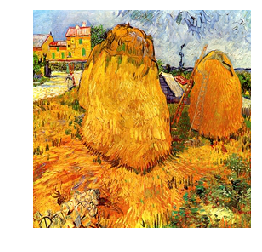

In [192]:
from PIL import Image
import os
import numpy as np
import random
from imageio import imread

a_train = []
a_path = os.path.join(dataset_path, "trainA")
# 走過A分類(梵谷)的所有照片
for fname in os.listdir(a_path):
    img_path = os.path.join(a_path, fname)
    if not fname.startswith("."):
        a_train.append(img_path)
# 隨機選一個印出來
i = random.randint(0, len(a_train) - 1)
a_img = imread(a_train[i])
plt.axis("off")
plt.imshow(a_img)
print("訓練資料(梵谷)維度:", a_img.shape)

訓練資料(風景)維度: (256, 256, 3)


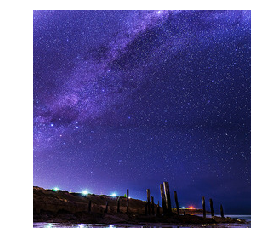

In [195]:
b_train = []
b_path = os.path.join(dataset_path, "trainB")
# 走過B分類(風景)的所有照片
for fname in os.listdir(b_path):
    img_path = os.path.join(b_path, fname)
    if not fname.startswith("."):
        b_train.append(img_path)

i = random.randint(0, len(b_train) - 1)
b_img = imread(b_train[i])
plt.axis("off")
plt.imshow(b_img)
print("訓練資料(風景)維度:", b_img.shape)

## ✔ Step2. 設計Discriminator

### 全卷積

這裡使用全卷積，放棄了全連接層，對於圖片來說，全卷積可以正確地抓出圖片的隱含特徵

### 全卷積步長和視野窗

最新的概念裡，我們不使用池化層來減少計算量和縮小圖片了，因為池化其實就意味著放棄資料

我們現在喜歡使用帶步長的卷積層，像下圖的步長2，一次走兩格，長寬自然就縮小了一半

![](stride.png)

> 大家通常會選用(4, 4)卷積窗和步長2  

因為如果你的步長不能整除卷積窗的話，會有貢獻不均衡的問題

我們把不均衡的例子放在下面

![](unbalanced.png)

你會發現我們的步長3沒辦法整除卷積窗的大小4

這樣就會有人只貢獻一次，很容易讓我們的特徵抓取變成一個不均衡的抓取

### LeakyRelu

激活的函數，以前我們都選擇relu，但是relu有個很嚴重的問題，就是到了死亡區斜率就變0，那這次梯度下降就是0，也就是不下降，而且weights來到死亡區很容易所有資料來到這神經元都會死亡，這時候我們就稱為這神經元『死亡』了

對於比較複雜的GAN，網路極其脆弱，所以很容易就死亡了，這裡改進的方法就是改使用leakyrelu

![](leakyrelu.png)

讓負區的斜率不為0，但是是一個很小的值就好了

### InstanceNormalization

我們上次在標準GAN裡有說過Batch Normalization，簡單來說就是把一個Batch所有的資料標準化

目的是為了配合模型的weights，並且也不會整團資料分佈在一個奇怪的地方

但是我們在做CycleGAN的時候，由於每一張圖片差距太大，所以我們改成使用InstanceNormalization，對於每一張圖片(而非一個batch)做標準化

In [7]:
# 因為我們需要兩個Discriminator, 所以我們把它定義成函數
def build_discriminator():

    def d_layer(layer_input, filters, f_size=(4, 4)):
        d = Conv2D(filters, kernel_size=f_size, 
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d

    img = Input(shape=(256, 256, 3))

    d1 = d_layer(img, 64)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d2, 256)
    d4 = d_layer(d3, 512)
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)


## ✔ Step2. 設計Generator

generator是卷積(抓出A的真正特徵) + 反卷積(以這些特徵構築B)的結果

### 反卷積

反卷積其實就是卷積的相反，這裡我們使用UpSampleing層加上一次的卷積完成一次的反卷積

> Size(2, 2)的UpSampling是把每一個數字複製4個，變成 2 * 2 的同一數字  

記得這裡卷積就必須把步長設定為1了

因為並沒有要改變我們的寬度

### Concatenate層

這裡比較特別一點，因為我們並不想讓整個GAN產生的結果跟原圖差十萬八千里

所以我們還會順便在反卷積的時候把相對應的卷積層當成Embedding傳入，希望這些特徵可以幫我們在AB轉換的時候還是維持原圖的特徵

In [6]:
def build_generator():

    def conv2d(layer_input, filters, f_size=(4, 4)):
        d = Conv2D(filters, kernel_size=f_size, 
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=(4, 4)):
        u = UpSampling2D(size=(2, 2))(layer_input)
        u = Conv2D(filters, kernel_size=f_size, 
                   strides=1, padding='same')(u)
        u = LeakyReLU(alpha=0.2)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    d0 = Input(shape=(256, 256, 3))

    d1 = conv2d(d0, 32)
    d2 = conv2d(d1, 64)
    d3 = conv2d(d2, 128)
    d4 = conv2d(d3, 256)

    u1 = deconv2d(d4, d3, 128)
    u2 = deconv2d(u1, d2, 64)
    u3 = deconv2d(u2, d1, 32)
    u3 = deconv2d(d2, d1, 32)


    u4 = UpSampling2D(size=(2, 2))(u3)
    output_img = Conv2D(3, kernel_size=(4, 4), 
                        strides=1, padding='same', 
                        activation='tanh')(u4)

    return Model(d0, output_img)

## ✔ Step3. 建立模型並編譯

### 調整Adam優化器

由於我們的GAN非常脆弱，所以我希望能稍微讓我們的優化器再調整一下

![](adam.png)

通常我們不希望我們的Discriminator變好的太快，因為Generator就會無所適從，不知道如何變好

所以我們會把learning rate(更新weights前面成的常數)變小一點，根據大家的經驗法則，0.0002是一個很不錯的學習速率

那這邊我通常也會把動量(Adam是基於動量的一個優化器)調整小一點

總之，我這裡希望放慢一點鑑賞家變慢的速度

### Loss

因為我們的Discriminator使用的是全卷積，所以最後還是輸出有寬和高

那我們就不能用以往的Binary CrossEntropy來判定了，所以我們改用Mean Square Error(距離平方再開根號)來當作我們的損失

In [8]:
from keras.optimizers import Adam
op = Adam(0.0002, 0.5)
d_A = build_discriminator()
d_A.compile(loss='mse',
    optimizer=op,
    metrics=['accuracy'])
d_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
instance_normalization_1 (In (None, 128, 128, 64)      2         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_2 (In (None, 64, 64, 128)       2         
__________

In [9]:
d_B = build_discriminator()
d_B.compile(loss='mse',
    optimizer=op,
    metrics=['accuracy'])
d_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
instance_normalization_5 (In (None, 128, 128, 64)      2         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_6 (In (None, 64, 64, 128)       2         
__________

### 合併模型

跟傳統GAN一樣，創立一個合併模型，詳細步驟我們註解在程式碼上

In [10]:
# 建立Generator, 不過不用編譯, 因為我們沒有要訓練他
g_AB = build_generator()
g_BA = build_generator()
# 輸入圖片的大小
img_A = Input(shape=(256, 256, 3))
img_B = Input(shape=(256, 256, 3))

# 創造偽作
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)
# 偽作再偽造回原作
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)
# 這裡比較特別, 我們希望A類的圖片就算丟進A->B轉換還是維持
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# 記得在合併模型的時候我們要固定住Discriminator
d_A.trainable = False
d_B.trainable = False

# 對兩個偽作接上Discriminator
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# 這裡我們由於有多個ouput, 所以也要接多個loss
# mse會對預測很差的做很大的懲罰
# 對於畫, 我們沒有要給很大的懲罰, 所以我們選擇mae
combined = Model(inputs=[img_A, img_B],
                 outputs=[ valid_A, valid_B,
                           reconstr_A, reconstr_B,
                           img_A_id, img_B_id ])
combined.compile(loss=['mse', 'mse',
                       'mae', 'mae',
                       'mae', 'mae'],
                 loss_weights=[  1, 1,
                                10, 10,
                                 1, 1],
                 optimizer=op)
combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 256, 256, 3)  70281       input_6[0][0]                    
                                                                 model_3[1][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_3 (M

## ✔ Step4. 訓練模型

由於我們是全卷積，所以必須把寬高都填滿1，那最後輸出只有一個通道，所以是(16, 16, 1)

In [197]:
patch = int(256 / 2**4)
disc_patch = (patch, patch, 1)
disc_patch

(16, 16, 1)

因為一次訓練一張圖，所以我們只需要(1, 16, 16, 1) -> (一張圖, 寬, 高, 通道數)

In [199]:
valid = np.ones((1,) + disc_patch)
fake = np.zeros((1,) + disc_patch)

大概訓練了數萬次，只取最後的幾次

In [189]:
batch_size = 1
train_count = 5
d_loss_list = []
g_loss_list = []
for train in range(0, train_count):
    dash = "-" * 15
    print(dash, "Train", train, dash)

        
    ida = np.random.randint(0, len(a_train), batch_size)
    idb = np.random.randint(0, len(b_train), batch_size)


    imgs_A = []
    imgs_B = []
    for i in ida:
        imgs_A.append((imread(a_train[i]) - 127.5)/127.5)
    for i in idb:
        imgs_B.append((imread(b_train[i]) - 127.5)/127.5)
    imgs_A = np.array(imgs_A)
    imgs_B = np.array(imgs_B)

    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)  

    d_A.trainable = True
    d_B.trainable = True
    dA_loss_real = d_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = d_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

    dB_loss_real = d_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = d_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

    # Total disciminator loss
    d_loss = 0.5 * np.add(dA_loss, dB_loss)


    d_A.trainable = False
    d_B.trainable = False
    g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                            [valid, valid,
                                            imgs_A, imgs_B,
                                            imgs_A, imgs_B])
        
    dash = "-" * 15
    print("Discriminator loss:", d_loss)
    print("Generator loss:", g_loss)
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)



--------------- Train 0 ---------------
Discriminator loss: [0.02281462 1.        ]
Generator loss: [3.9857652, 0.89864177, 0.7574793, 0.101250775, 0.072771996, 0.2323237, 0.3570928]
--------------- Train 1 ---------------
Discriminator loss: [0.2055629 0.75     ]
Generator loss: [3.002908, 0.97745234, 0.105900034, 0.09675653, 0.07022899, 0.1215199, 0.12818071]
--------------- Train 2 ---------------
Discriminator loss: [0.02731891 1.        ]
Generator loss: [3.7201955, 1.074858, 0.77537143, 0.05991071, 0.09943257, 0.14868948, 0.12784383]
--------------- Train 3 ---------------
Discriminator loss: [0.10703883 0.79589844]
Generator loss: [3.515755, 1.0189565, 0.6486736, 0.09558727, 0.058565624, 0.22159313, 0.085002884]
--------------- Train 4 ---------------
Discriminator loss: [0.10798818 0.86328125]
Generator loss: [3.2700064, 1.074095, 0.349965, 0.06928012, 0.07942289, 0.2272602, 0.13165641]


## ✔ Step5. 看看結果

原本的畫

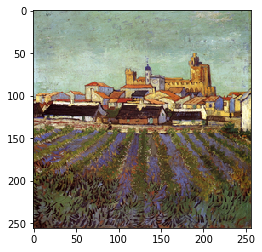

In [63]:
idx = random.randint(0, len(a_train) - 1)
drawing = imread(a_train[idx])
plt.imshow(drawing)

In [64]:
drawing_shaped = (drawing - 127.5)/127.5


轉換成風景後

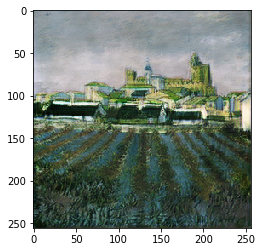

In [190]:
fake_scenery = g_AB.predict(np.array([drawing_shaped]))
fake_scenery = 0.5 * fake_scenery + 0.5
plt.imshow(fake_scenery[0])

原本的風景

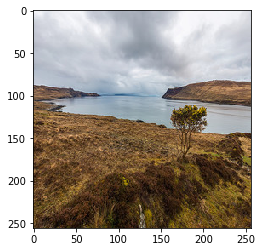

In [128]:
idx = random.randint(0, len(b_train) - 1)
scenery = imread(b_train[idx])
plt.imshow(scenery)

In [129]:
scenery_shaped = (scenery - 127.5)/127.5

轉換成梵谷風

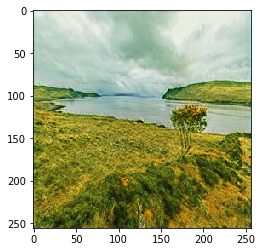

In [191]:
fake_drawing = g_BA.predict(np.array([scenery_shaped]))
fake_drawing = 0.5 * fake_drawing + 0.5
plt.imshow(fake_drawing[0])

列出多一點，你可以看得出，有些轉換隱隱有梵谷的影子了

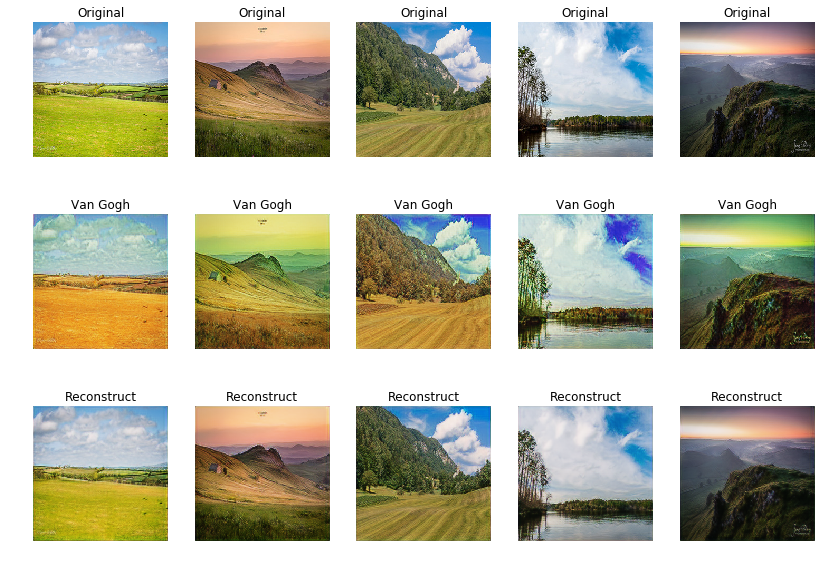

In [181]:
drawbatch = 5
idx = np.random.randint(0, len(b_train), drawbatch)

scenery_batch = []
drawing_batch = []
reconstruct_batch = []

for i in idx:
    scenery_i = imread(b_train[i])
    scenery_i_shaped = (scenery_i - 127.5)/127.5
    scenery_batch.append(scenery_i)
    fake_drawing_i = g_BA.predict(np.array([scenery_i_shaped]))
    reconstruct_i = g_AB.predict(fake_drawing_i)
    fake_drawing_i = 0.5 * fake_drawing_i + 0.5    
    drawing_batch.append(fake_drawing_i[0])
    reconstruct_i = 0.5 * reconstruct_i + 0.5    
    reconstruct_batch.append(reconstruct_i[0])

    
plt.figure(figsize = (14,10))
for (i, draw) in enumerate(scenery_batch):   
    plt.subplot(3, drawbatch, i + 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(draw)
for (i, draw) in enumerate(drawing_batch):   
    plt.subplot(3, drawbatch, drawbatch + (i + 1))
    plt.title("Van Gogh")
    plt.axis("off")
    plt.imshow(draw)
for (i, draw) in enumerate(reconstruct_batch):   
    plt.subplot(3, drawbatch, 2 * drawbatch + (i + 1))
    plt.title("Reconstruct")
    plt.axis("off")
    plt.imshow(draw)

In [20]:
d_A.save("davangogh.h5")
d_B.save("dbvangogh.h5")
g_AB.save("gabvangogh.h5")
g_BA.save("gbavangogh.h5")
combined.save("combinedvangogh.h5")